In [1]:
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
pd.options.mode.chained_assignment = None

In [2]:
#畫圖時不需要對圖形輸入.show() 就可以呈現圖形
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sampleSubmission.csv')

In [4]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [5]:
# 沒有空值要小心,可能資料者用某種方式補齊空值但會影響後續分析
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [7]:
train.describe()

# 可發現count欄位的max值跟50%、75%相比太大，有outlier的情況
# 對比下面test資料，發現test沒有casual和registered欄位，所以對train來說這兩欄沒有幫助，可去掉

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


### Feature Engineering

In [9]:
# 當你資料大於或小於平均加上或減掉3倍標準差，可判斷是outlier
# 將count欄位的outlier值去掉，比較去掉前後總筆數差100多筆

print ("Shape of The Before Outliers:", train.shape)
train = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())]
print ("Shape of The After Outliers: ", train.shape)

Shape of The Before Outliers: (10886, 12)
Shape of The After Outliers:  (10739, 12)


In [10]:
# 資料前處理train和test一起做，所以很多時候會先把train和test合併起來一起處理，處理完再拆開
# 合併資料

data = train.append(test)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

In [11]:
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17227,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17228,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17229,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17230,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [12]:
data['datetime'][0]

'2011-01-01 00:00:00'

In [13]:
# 處理datetime欄位

data["date"] = data.datetime.apply(lambda x : x.split()[0])
data["hour"] = data.datetime.apply(lambda x : x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x : x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString, "%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString, "%Y-%m-%d").month)

In [14]:
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,year,weekday,month
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0,2011-01-01,0,2011,5,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0,2011-01-01,1,2011,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0,2011-01-01,2,2011,5,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0,2011-01-01,3,2011,5,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0,2011-01-01,4,2011,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17227,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012-12-31,19,2012,0,12
17228,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012-12-31,20,2012,0,12
17229,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN,2012-12-31,21,2012,0,12
17230,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN,2012-12-31,22,2012,0,12


[Text(0.5, 0, 'windspeed'), Text(0.5, 1.0, 'distribution of windspeed')]

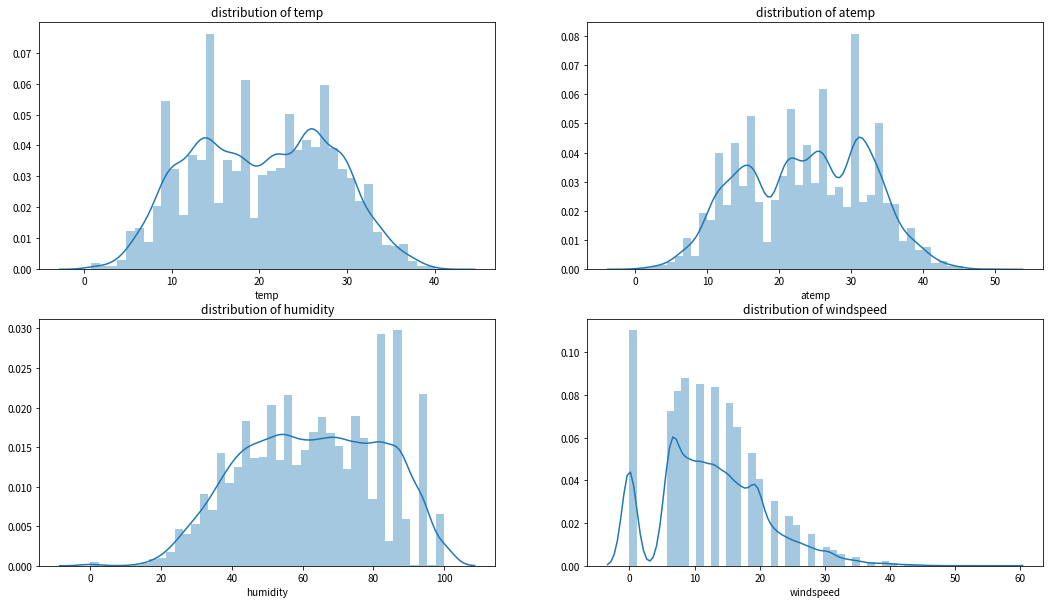

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(18, 10)

# 畫圖形
sns.distplot(data["temp"], ax=axes[0][0])
sns.distplot(data["atemp"], ax=axes[0][1])
sns.distplot(data["humidity"], ax=axes[1][0])
sns.distplot(data["windspeed"], ax=axes[1][1])

# 圖形調整
axes[0][0].set(xlabel='temp', title="distribution of temp")
axes[0][1].set(xlabel='atemp', title="distribution of atemp")
axes[1][0].set(xlabel='humidity', title="distribution of humidity")
axes[1][1].set(xlabel='windspeed', title="distribution of windspeed")

# 圖表上的曲線代表荷密度函數
# 風速突有異常，是關鍵，直方圖中間很多空隙，可能是因為這儀器不穩定，很多數直沒測量到

In [16]:
dataWind0 = data[data["windspeed"]==0]
dataWindNot0 = data[data["windspeed"] !=0]
rfModel_wind = RandomForestRegressor(n_estimators=1000, random_state=42)
windColumns = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
dataWind0.loc[:, "windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

<AxesSubplot:xlabel='windspeed'>

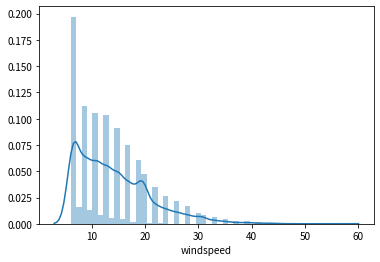

In [17]:
sns.distplot(data["windspeed"])

In [18]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsLog = np.log(yLabels)

#對Y取log是因為y原本的圖形不是常態分配，取log後比較像常態分配

In [19]:
dropFeatures = ['casual', "count", "datetime", "date", "registered"]
dataTrain = dataTrain.drop(dropFeatures, axis = 1)
dataTest = dataTest.drop(dropFeatures, axis =1)

<AxesSubplot:xlabel='count'>

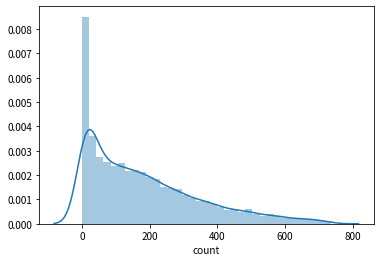

In [20]:
sns.distplot(yLabels)

<AxesSubplot:xlabel='count'>

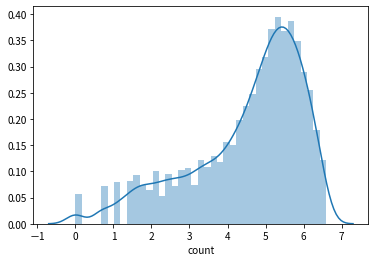

In [22]:
sns.distplot(yLabelsLog)

In [25]:
#預測dataTrain

rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)
yLabelsLog = np.log(yLabels)
rfModel.fit(dataTrain, yLabelsLog)
preds = rfModel.predict(X= dataTrain)

In [26]:
preds

array([2.98651299, 3.44377777, 3.21724798, ..., 5.17058036, 4.93327532,
       4.54485271])

In [27]:
#預測dataTest

predsTest = rfModel.predict(X = dataTest)
submission = pd.DataFrame({
    "datetime": datetimecol,
    "count": [max(0, x) for x in np.exp(predsTest)]
})
submission.to_csv('bike_predictions_RF.csv', index=False)

In [28]:
submission

,datetime,count
9442,2011-01-20 00:00:00,10.741879
16365,2011-01-20 01:00:00,4.849942
16366,2011-01-20 02:00:00,2.918483
9443,2011-01-20 03:00:00,3.032553
9444,2011-01-20 04:00:00,2.577142
...,...,...
15063,2012-12-31 19:00:00,286.456685
15064,2012-12-31 20:00:00,201.479803
15065,2012-12-31 21:00:00,137.885903
15066,2012-12-31 22:00:00,108.006960
